In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.cluster import GaussianCluster, AutoGMMCluster


In [2]:
!ln -s /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/notebooks/HSBM.py HSBM.py

usage: ln [-Ffhinsv] source_file [target_file]
       ln [-Ffhinsv] source_file ... target_dir
       link source_file target_file


In [3]:
from HSBM import RecursiveCluster

## synthetic Gaussian mixture data

### square-like (4 components at level 0)

In [4]:
def square_loc(center, length):
    left_bottom = np.array([center[0] - length/2, center[1] - length/2])
    right_up = np.array([center[0] + length/2, center[1] + length/2])
    left_up = np.array([center[0] - length/2, center[1] + length/2])
    right_bottom = np.array([center[0] + length/2, center[1] - length/2])

    return (left_bottom, right_bottom, left_up, right_up)

In [5]:
def GM_square(cov_scale, covariance_type='spherical', n_sample=100):
    center_lvl1 = np.array([0, 0])
    length_lvl1 = 10
    locs_lvl1 = square_loc(center_lvl1, length_lvl1)
    x = []
    for i in range(4):
        center_lvl2 = locs_lvl1[i]
        locs_lvl2 = square_loc(center_lvl2, length_lvl1 * cov_scale)
        gmm = GaussianMixture(n_components=4, covariance_type=covariance_type, random_state=i)
        gmm.fit(np.random.rand(4, 2))
        gmm.means_ = np.array(locs_lvl2)
        gmm.covariances_ = np.repeat(cov_scale, 4)
        gmm.weights_ = np.repeat(1/4, 4)
        gmm.precisions_cholesky_ = 0
        x_new, _ = gmm.sample(n_sample)
        x.append(x_new)

    return np.array(x)

In [6]:
scales = np.linspace(0.2, 0.9, num=8)
pred = []
for i in range(len(scales)):
    x = GM_square(scales[i])
    x = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    rc = RecursiveCluster(max_components=4, max_level=2)
    y = rc.fit_predict(x)
    pred.append(y)

In [25]:
lvl1_true = []
for i in range(4):
    l = np.repeat(i, 100)
    lvl1_true = np.concatenate([lvl1_true, l])
    
lvl2_true = []
for i in range(4*4):
    l = np.repeat(i, 25)
    lvl2_true = np.concatenate([lvl2_true, l])

In [158]:
aris = pd.DataFrame({"level1": np.zeros(len(scales)), "level2": np.zeros(len(scales))})
for i in range(len(scales)):
    ari = adjusted_rand_score(lvl1_true, pred[i]["lvl1_labels"])
    aris["level1"].iloc[i] = ari
    ari = adjusted_rand_score(lvl2_true, pred[i]["lvl2_labels"])
    aris["level2"].iloc[i] = ari

In [159]:
aris["cov_scale"] = scales
aris = aris.melt(id_vars=['cov_scale'], value_vars=['level1', 'level2'])
aris.columns = ["cov_scale", "lvl", "ARI"]

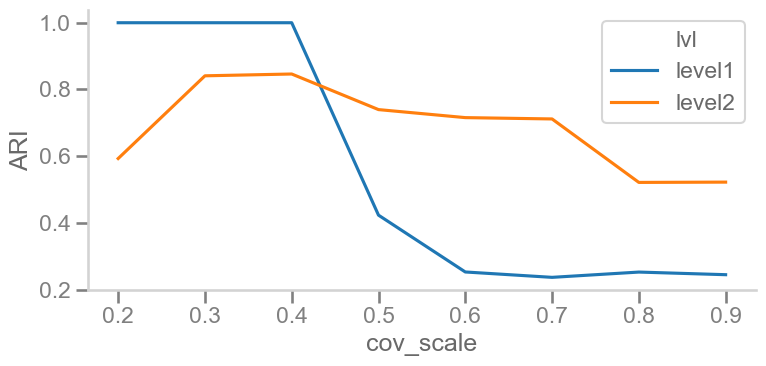

In [165]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

fig,ax = plt.subplots(1,figsize=(8,4))
sns.lineplot(data = aris, x="cov_scale", y="ARI", hue="lvl")
plt.tight_layout()
plt.savefig('2')

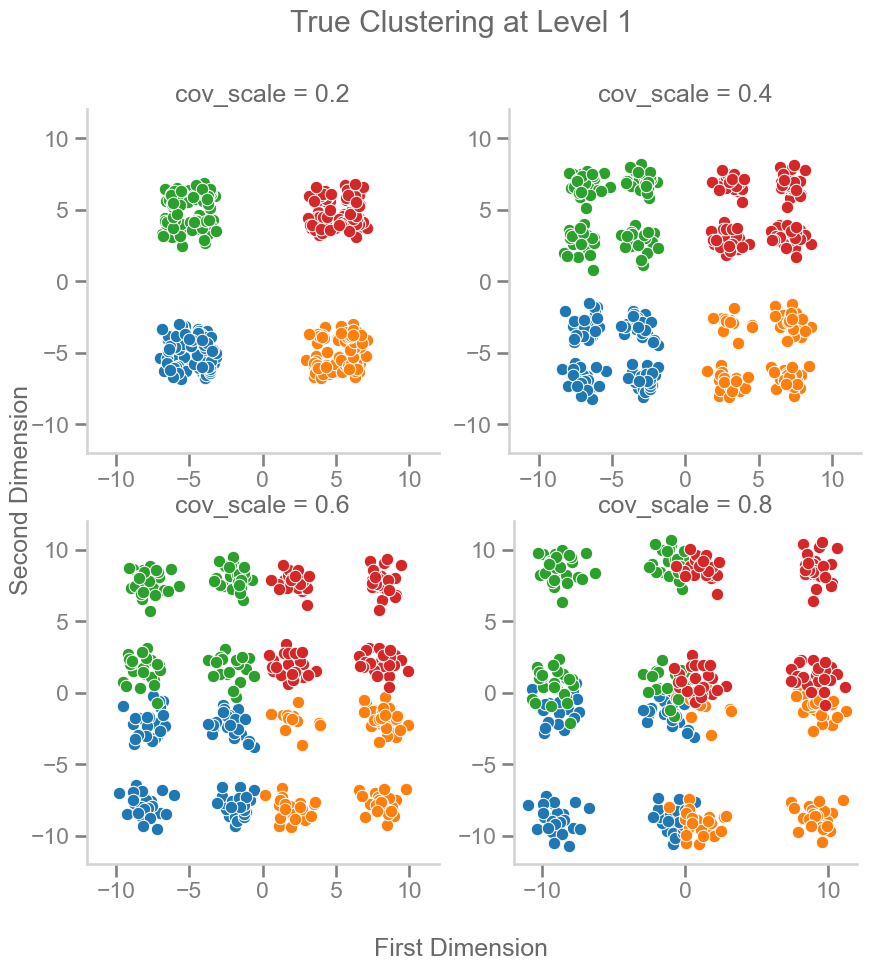

In [163]:
fig,axs = plt.subplots(2, 2, figsize=(10,10))
inds = [0,2,4,6]
idx = -1
for i in range(2):
    for j in range(2):
        idx += 1
        ax = axs[i, j]
        # ax.axis("off")
        x = GM_square(scales[inds[idx]])
        for k in range(4):
            sns.scatterplot(x[k,:,0],x[k,:,1], ax=ax)
            ax.set(title = "cov_scale = %.1f"%scales[inds[idx]])
            ax.set_xlim([-12,12])
            ax.set_ylim([-12,12])
            plt.gca().set_aspect('equal', adjustable='box')
fig.suptitle("True Clustering at Level 1")
fig.text(0.5, 0.04, 'First Dimension', ha='center', va='center')
fig.text(0.06, 0.5, 'Second Dimension', ha='center', va='center', rotation='vertical')
plt.savefig('1')

## 1-component GM samples

In [346]:
def GM_nested_lvl1(n_sample, cov, random_state, covariance_type='spherical'):
    gmm = GaussianMixture(n_components=1, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(np.random.rand(3, 2))
    gmm.means_ = np.array([[0,0]])
    gmm.covariances_ = np.array([cov])
    gmm.weights_ = np.array([1])
    gmm.precisions_cholesky_ = 0
    x, _ = gmm.sample(n_sample)

    return x

In [383]:
def GM_nested_lvl1up(x, n_sample, cov, cov_scale, covariance_type='spherical'):
    x1 = []
    for i in range(len(x)):
        gmm = GaussianMixture(n_components=1, covariance_type=covariance_type, random_state=i)
        gmm.fit(np.random.rand(3, 2))
        gmm.means_ = np.array([x[i,:]])
        gmm.covariances_ = np.array([cov * cov_scale])
        gmm.weights_ = np.array([1])
        gmm.precisions_cholesky_ = 0
        x_new, _ = gmm.sample(n_sample)
        x1.append(x_new)
    x1 = np.array(x1).reshape((len(x1) * x1[0].shape[0]), x1[0].shape[1]) 

    return x1

In [415]:
ite = 10
ys = []
for i in range(ite):
    x = GM_nested_lvl1(8, 10000, i)
    x1 = GM_nested_lvl1up(x, 8, 10000, 0.01)
    x2 = GM_nested_lvl1up(x1, 8, 10000*0.01, 0.01)
    rc = RecursiveCluster(max_components=8, max_level=2)
    y = rc.fit_predict(x2)
    ys.append(y)

In [399]:
l1_true = np.zeros(len(x2))
for i in range(len(x1)):
    l1_true[i*len(x1):(i+1)*len(x1)] += i

l2_true = []
for i in range(1,len(x) ** 2+1):
    l2_true.append(np.ones(len(x)) * i)
l2_true = np.array(l2_true).reshape((len(l2_true) * len(x)))

In [427]:
aris_1comp = pd.DataFrame({"1": np.zeros(len(ys)), "2": np.zeros(len(ys))})
for i in range(len(ys)):
    aris_1comp["1"].iloc[i] = adjusted_rand_score(l1_true, ys[i]["lvl1_labels"])
    aris_1comp["2"].iloc[i] = adjusted_rand_score(l2_true, ys[i]["lvl2_labels"])

aris_1comp = aris_1comp.melt(value_vars=['1', '2'])
aris_1comp.columns = ["level", "ARI"]

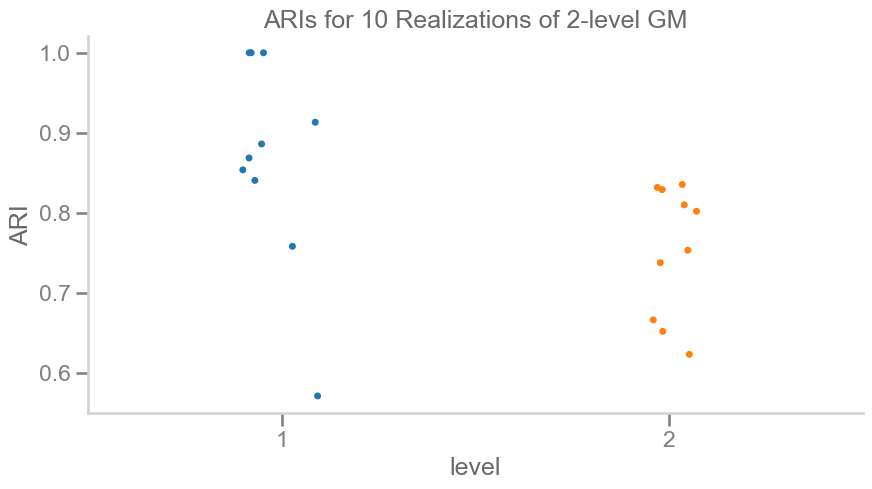

In [480]:
fig, ax = plt.subplots(1, figsize=(10,5))
sns.stripplot(data = aris_1comp, x="level", y="ARI", ax=ax)
ax.set_title("ARIs for 10 Realizations of 2-level GM")
plt.savefig('4')

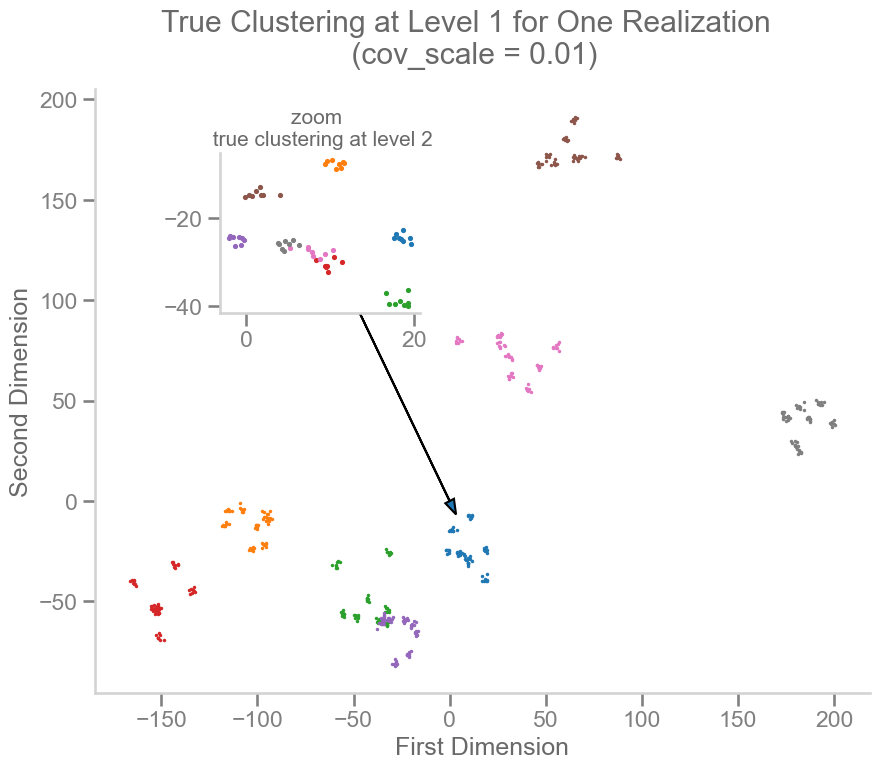

In [478]:
fig, ax = plt.subplots(1, figsize=(10,8))
for i in range(8):
    ax.scatter(x2[i*64:(i+1)*64,0],x2[i*64:(i+1)*64,1], s=1)

ax2 = plt.axes([0.25, 0.6, .2, .2])
for i in range(8):
    ax2.scatter(x2[i*8:(i+1)*8,0],x2[i*8:(i+1)*8,1], s=5)
ax2.set_title('zoom \n true clustering at level 2', fontsize=15)
ax.arrow(-50,100,50,-100, head_width=5)
fig.suptitle("True Clustering at Level 1 for One Realization \n (cov_scale = 0.01)")
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")

plt.savefig('3')

In [1]:
# df = df[df.duplicated(keep=False)]
# df = df.groupby(list(df).apply(lambda x: tuple(x.index))

# uni_label = df.drop_duplicates()

# uniq = df.drop_duplicates().reset_index(drop=True)
# d = dict()
# for idx, row in uniq.iterrows():
#     print(row)
#     d[idx] = df.index[(df == row).all(axis=1)].values

# np.unique(rows, return_counts=True, return_index=True, axis=0)

# labels_pred.loc[:,"2_pred"].replace("", -1)

# np.where((uni_labels[:,None,:] == labels_pred.values).all(2)[0])[0]

# [[node for node in children] for children in LevelOrderGroupIter(f)][-1]
# [node.name for node in LevelOrderIter(g)]